# Assessment of Renewable Energy Potentials based on Land Availability

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the third stage: **Scenarios**

-Goal: conduct analysis of power generation estimation, capacity, and capacity factor under assumptions.

-Steps: Setup the assumptions and use two different methods (total power density and time-serie data) to calculate the installed capacity and estimate the power generation for comparison 

1. Import data (data from stage 2, and hourly data)
2. Setup assumptions based on data (scenario3) from stage 2
3. Method I: Calculate the potentials capacity & annual generation via power density
4. Method II: Calculate the potentials capacity & annual generation via hourly data (01/01/2020-31/12/2020)

In [1]:
# import necessary library
# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline
import matplotlib.pyplot as plt # Convention for import of the pyplot interface
import os # operating system interfaces 
import datetime # time data sorting
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import seaborn as sns # Use seaborn style defaults and set the default figure size
import geopandas # geospatial data processing package
import shapely.speedups # geospatial data speedup package
import rasterio # geospatial data (raster file) processing package
import contextily # the package for fetching basemaps
import glob # finds all the pathnames matching a specified pattern
import elevation # for elevation processing
import richdem as rd # package to deal with slope rate
import pyproj # self-defined coordination reference system
import xarray as xr # deal with time series data (grib and NetCDF files)
from matplotlib.patches import Patch # for legend editing
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler
from geopandas import datasets, GeoDataFrame, read_file # geospatial data processing package
from geopandas.tools import overlay # for overlay function
from shapely import wkt # provide dumpers and loaders inspired by Python’s pickle module
from shapely.geometry import Point # processing for data in point form
from rasterio.merge import merge
from rasterio.plot import show # plot the raster data
from rasterio.plot import show_hist
from rasterstats import zonal_stats
from pyproj import CRS # self-defined coordination reference system
from pyproj import Geod # performs forward and inverse geodetic, or Great Circle, computations
from osgeo import gdal, gdal_array

In [2]:
# spped up the calculation of mapping in shapely library
shapely.speedups.enable()

## 1. Import data (data from stage 2, time-series data)

a. Import the **land area** which is **scenario 3** from the **result of stage 2**

b. Import the **hourly data** for calculation (01/01/2020-31/12/2020)

In [3]:
# Import final available land (from stgae 2)
land_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.csv')

# Import result data of wind resources from stge 2
sc3_wind_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_wind.csv')

# Import result data of solar resources from stge 2
sc3_solar_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_solar.csv')

In [4]:
# import data (ERA5, Latitude x Longtitude: 0.25° x 0.25°) (01/01/2020-31/12/2020)
ds = xr.open_dataset('Vietnam/00_data_time_series/hourly_data_2020_era5.nc')
# convert time series data (ds) to dataframe
df = ds.to_dataframe()

# drop all index
df.reset_index(drop=False, inplace=True)

# reset time column into date time and select it as new index
df["time"] = pd.to_datetime(df["time"])
df.set_index('time')

# add year, month and day name
df['year'] = pd.DatetimeIndex(df['time']).year
df['month'] = pd.DatetimeIndex(df['time']).month
df['day'] = pd.DatetimeIndex(df['time']).day
df['hour'] = pd.DatetimeIndex(df['time']).hour
df.head()

,latitude,longitude,time,u100,v100,fdir,year,month,day,hour
0,24.0,101.0,2020-01-01 00:00:00,0.498847,0.980772,0.000,2020,1,1,0
1,24.0,101.0,2020-01-01 01:00:00,0.199315,0.907117,24523.625,2020,1,1,1
2,24.0,101.0,2020-01-01 02:00:00,0.110454,0.916045,97986.875,2020,1,1,2
3,24.0,101.0,2020-01-01 03:00:00,0.580720,0.776548,263574.875,2020,1,1,3
4,24.0,101.0,2020-01-01 04:00:00,0.564745,0.695081,266317.625,2020,1,1,4


In [5]:
df

,latitude,longitude,time,u100,v100,fdir,year,month,day,hour
0,24.0,101.0,2020-01-01 00:00:00,0.498847,0.980772,0.000,2020,1,1,0
1,24.0,101.0,2020-01-01 01:00:00,0.199315,0.907117,24523.625,2020,1,1,1
2,24.0,101.0,2020-01-01 02:00:00,0.110454,0.916045,97986.875,2020,1,1,2
3,24.0,101.0,2020-01-01 03:00:00,0.580720,0.776548,263574.875,2020,1,1,3
4,24.0,101.0,2020-01-01 04:00:00,0.564745,0.695081,266317.625,2020,1,1,4
...,...,...,...,...,...,...,...,...,...,...
21125515,8.0,110.0,2020-12-31 19:00:00,-5.289115,-15.907325,0.000,2020,12,31,19
21125516,8.0,110.0,2020-12-31 20:00:00,-5.260160,-16.031200,0.000,2020,12,31,20
21125517,8.0,110.0,2020-12-31 21:00:00,-5.927119,-15.979863,0.000,2020,12,31,21
21125518,8.0,110.0,2020-12-31 22:00:00,-6.913579,-14.794694,0.000,2020,12,31,22


In [6]:
# wind time series data
# wind speed = (u**2 + v**2)**(1/2)
df['wind_speed_at_height_100m[m/s]'] = ((df['u100'])**2 + (df['v100'])**2)**(1/2)

# solar time series data
# from j/m2 to kWh/m2
# 1kwh = 3.6 x10**6 j
df['total_sky_direct_solar_radiation_at_surface[Wh/m2]'] = df['fdir']/(3.6*(10**3))

#rename the titles
# create a dictionary and renew the titles

dict = {'u100': 'u-component_of_wind_speed_at_height_100m[m/s]',
        'v100': 'v-component_of_wind_speed_at_height_100m[m/s]',
        'fdir': 'total_sky_direct_solar_radiation_at_surface[J/m2]',
       }

# call rename () method
df.rename(columns=dict,
          inplace=True)

df = df[['latitude', 'longitude', 'time', 'year', 'month', 'day', 'hour',
         'u-component_of_wind_speed_at_height_100m[m/s]', 
         'v-component_of_wind_speed_at_height_100m[m/s]', 
         'wind_speed_at_height_100m[m/s]',
         'total_sky_direct_solar_radiation_at_surface[J/m2]', 
         'total_sky_direct_solar_radiation_at_surface[Wh/m2]']]
df.head()

,latitude,longitude,time,year,month,day,hour,u-component_of_wind_speed_at_height_100m[m/s],v-component_of_wind_speed_at_height_100m[m/s],wind_speed_at_height_100m[m/s],total_sky_direct_solar_radiation_at_surface[J/m2],total_sky_direct_solar_radiation_at_surface[Wh/m2]
0,24.0,101.0,2020-01-01 00:00:00,2020,1,1,0,0.498847,0.980772,1.100346,0.000,0.000000
1,24.0,101.0,2020-01-01 01:00:00,2020,1,1,1,0.199315,0.907117,0.928756,24523.625,6.812118
2,24.0,101.0,2020-01-01 02:00:00,2020,1,1,2,0.110454,0.916045,0.922680,97986.875,27.218576
3,24.0,101.0,2020-01-01 03:00:00,2020,1,1,3,0.580720,0.776548,0.969671,263574.875,73.215240
4,24.0,101.0,2020-01-01 04:00:00,2020,1,1,4,0.564745,0.695081,0.895586,266317.625,73.977119


## 2. Setup assumptions based on data (scenario3) from stage 2

### a. Calculate the total land area

In [21]:
name = 'Vietnam'
land_sum = land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Total areas in square kilometers
print('Total area of scenario 3 in', name, ':', land_sum,'km^2')

Total area of scenario 3 in Vietnam : 1611.7824709170907 km^2


### b. Divide the land area into different regions in Vietnam
The regions area defined based on https://en.wikipedia.org/wiki/List_of_regions_of_Vietnam

In [22]:
# separate into regions: Northeast, Northwest, Red River Delta, North Central Coast, South Central Coast, Central Highlands, Southeast, Mekong River Delta 
# Northwest
nw_list = ['Dien Bien','Hoa Binh', 'Lai Chau', 'Lao Cai', 'Son La', 'Yen Bai']
nw_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(nw_list))]
# Northeast
ne_list = ['Bac Giang','Bac Kann', 'Cao Bangu', 'Ha Giang', 'Lang Son', 'Phu Tho', 'Quang Ninh', 'Thai Nguyen', 'Tuyen Quang']
ne_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ne_list))]
# Red River Delta
rrd_list = ['Bac Ninh', 'Ha Nam', 'Ha Noi', 'Hai Duong', 'Hai Phong', 'Hung Yen', 'Nam Dinh', 'Ninh Binh', 'Thai Binh', 'Vinh Phuc']
rrd_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(nw_land_df))]
# North Central Coast
ncc_list = ['Ha Tinh', 'Nghe An', 'Quang Binh', 'Quang Tri', 'Thanh Hoa', 'Thua Thien Hue']
ncc_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ncc_list))]
# South Central Coast
scc_list = ['Binh Dinh', 'Binh Thuan', 'Da Nang', 'Khanh Hoa', 'Ninh Thuan', 'Phu Yen', 'Quang Nam', 'Quang Ngai']
scc_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(scc_list))]
# Central Highlands
ch_list = ['Dak Lak', 'Dak Nong', 'Gia Lai', 'Kon Tum', 'Lam Dong']
ch_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ch_list))]
# Southeast
se_list = ['Ba Ria Vung Tau', 'Binh Duong', 'Binh Phuoc', 'Dong Nai', 'Saigon', 'Tay Ninh']
se_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(se_list))]
# Mekong River Delta
mrd_list = ['An Giang', 'Ben Tre', 'Bac Lieu', 'Ca Mau', 'Can Tho City', 'Dong Thap', 'Hau Giang',
             'Kien Giang', 'Long An', 'Soc Trang', 'Tien Giang', 'Tra Vinh', 'Vinh Long']
mrd_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(mrd_list))]

### c. Define locations of each region (longtitude/latitude)

The approach uses locations (longitude/latitude) of one city in each region as a representative to do further comparison and analysis.

In [23]:
# tme-series data (ERA5, Latitude x Longtitude: 0.25° x 0.25°)

# Northwest: select a point close to Son La City (21.25, 104)
nw_loc = (df['latitude'] == 21.25) & (df['longitude'] == 104)
nw_loc_df = df.loc[nw_loc]

# Northeast: select a point close to Lang Son City (21.75, 106.75)
ne_loc = (df['latitude'] == 21.75) & (df['longitude'] == 106.75)
ne_loc_df = df.loc[ne_loc]

# Red River Delta: select a point close to Ha Noi City (21.00, 105.75)
rrd_loc = (df['latitude'] == 21) & (df['longitude'] == 105.75)
rrd_loc_df = df.loc[rrd_loc]

# North Central Coast: select a point close to Hue City (16.50, 107.50)
ncc_loc = (df['latitude'] == 16.5) & (df['longitude'] == 107.5)
ncc_loc_df = df.loc[ncc_loc]

# South Central Coast: select a point close to Da Nang City (16.00, 108.25)
scc_loc = (df['latitude'] == 16) & (df['longitude'] == 108.25)
scc_loc_df = df.loc[scc_loc]

# Central Highlands: select a point close to Buon Ma Thuot City (12.75, 108.00)
ch_loc = (df['latitude'] == 12.75) & (df['longitude'] == 108)
ch_loc_df = df.loc[ch_loc]

# Southeast: select a point close to Ho Chi Minh City (10.75, 106.75)
se_loc = (df['latitude'] == 10.75) & (df['longitude'] == 106.75)
se_loc_df = df.loc[se_loc]

# Mekong River Delta: select a point close to Can Tho City (10, 105.5)
mrd_loc = (df['latitude'] == 10) & (df['longitude'] == 105.5)
mrd_loc_df = df.loc[mrd_loc]

### d. Calculate the land area of different regions

In [24]:
region_name = ['Northwest', 'Northeast', 'Red River Delta', 'orth Central Coast', 'South Central Coast', 'Central Highlands', 'Southeast', 'Mekong River Delta']

# Northwest
nw_land_sum = nw_land_df['area_km2'].sum(axis = 0, skipna = True)
# Northeast
ne_land_sum = ne_land_df['area_km2'].sum(axis = 0, skipna = True)
# Red River Delta
rrd_land_sum= rrd_land_df['area_km2'].sum(axis = 0, skipna = True)
# North Central Coast
ncc_land_sum = ncc_land_df['area_km2'].sum(axis = 0, skipna = True)
# South Central Coast
scc_land_sum = scc_land_df['area_km2'].sum(axis = 0, skipna = True)
# Central Highlands
ch_land_sum = ch_land_df['area_km2'].sum(axis = 0, skipna = True)
# Southeast
se_land_sum = se_land_df['area_km2'].sum(axis = 0, skipna = True)
# Mekong River Delta
mrd_land_sum = mrd_land_df['area_km2'].sum(axis = 0, skipna = True)

# Total areas in square kilometers
print('Total area of scenario 3 in \n',
      region_name[0], ':', nw_land_sum,'km^2 \n',
      region_name[1], ':', ne_land_sum,'km^2 \n',
      region_name[2], ':', rrd_land_sum,'km^2 \n',
      region_name[3], ':', ncc_land_sum,'km^2 \n',
      region_name[4], ':', scc_land_sum,'km^2 \n',
      region_name[5], ':', ch_land_sum,'km^2 \n',
      region_name[6], ':', se_land_sum,'km^2 \n',
      region_name[7], ':', mrd_land_sum,'km^2')

Total area of scenario 3 in 
 Northwest : 8.202899173828696 km^2 
 Northeast : 87.17808683301098 km^2 
 Red River Delta : 0.0 km^2 
 orth Central Coast : 27.929101440956394 km^2 
 South Central Coast : 0.0487352973484093 km^2 
 Central Highlands : 0.0 km^2 
 Southeast : 24.939239965118528 km^2 
 Mekong River Delta : 1170.3630174142522 km^2


### c. Plot Graph of Available Land in Scenario3 of Different Regions

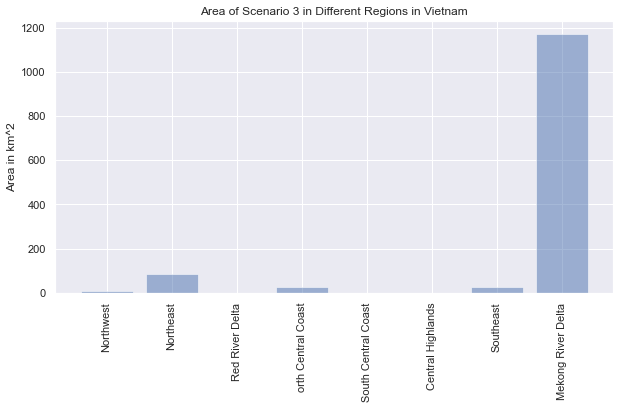

In [39]:
area_name_arr = ['Northwest', 'Northeast', 'Red River Delta', 'orth Central Coast', 'South Central Coast', 'Central Highlands', 'Southeast', 'Mekong River Delta']
y_pos = np.arange(len(area_name_arr))
area_sum_arr = [nw_land_sum, ne_land_sum, rrd_land_sum, ncc_land_sum, scc_land_sum, ch_land_sum, se_land_sum, mrd_land_sum]
sns.set(rc={'figure.figsize':(10,5)})
plt.bar(y_pos, area_sum_arr, align='center', alpha=0.5)
plt.xticks(y_pos, area_name_arr, rotation='vertical')
plt.ylabel('Area in km^2')
plt.title('Area of Scenario 3 in Different Regions in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_area_scenario3_regions.tiff',bbox_inches='tight', dpi=300)
plt.show()

## 3. Method I: Calculate the potentials capacity & annual generation via power density

### a. Calculate the potential capacity based on HC/LC profile assumptions

In [25]:
# wind
# HC/LC profile
# capactiy of one wind turbine according to High Capacity (HC) Profile (5 MW)
wt_hc_c = 5
# capactiy of one wind turbine according to Low Capacity (LC) Profile (2 MW)
wt_lc_c = 2
# distance between wind turbine: L*W = (5*rotor diameter)*(5*rotor diameter) (km2)
wt_d = 5*0.1*5*0.1

# potential capacity of HC/LC profile (GW) = (land area * capacity of one wind turbine) / (distance between wind turbines * 1000)
wt_pc_lc = land_sum*wt_lc_c/wt_d/1000
wt_pc_hc = land_sum*wt_hc_c/wt_d/1000
print('Onshore wind potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', wt_pc_lc,'GW', '\n (2) HC Profile:', wt_pc_hc,'GW')

Onshore wind potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 12.894259767336726 GW 
 (2) HC Profile: 32.235649418341815 GW


In [43]:
# solar
# HC/LC profile
# capactiy of one PV panel according to High Capacity (HC) Profile (450 Wp) / Power Density (150 MW/km2)
pv_hc_c = 450
pv_hc_pd = 150
# capactiy of one PV panel according to Low Capacity (LC) Profile (300 Wp)/ Power Density (60 MW/km2)
pv_lc_c = 300
pv_lc_pd = 60
# efficiency factor of the PV modules: 20 (%)
pv_ef = 0.2

# potential capacity of HC/LC profile (GW) = (land area * power density of one PV panel) / 1000
pv_pc_lc = land_sum*pv_lc_pd/1000
pv_pc_hc = land_sum*pv_hc_pd/1000
print('Utility-Scale PV potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', pv_pc_lc,'GW', '\n (2) HC Profile:', pv_pc_hc,'GW')

Utility-Scale PV potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 96.70694825502545 GW 
 (2) HC Profile: 241.7673706375636 GW


### b. Plot Graph of Potential Capacity in Scenario3 of Different Profiles

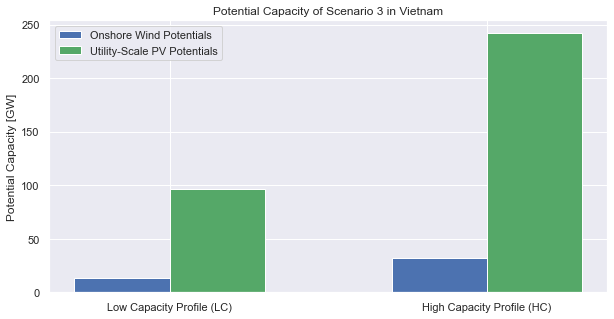

In [27]:
cap_arr = ['Low Capacity Profile (LC)', 'High Capacity Profile (HC)']
y_pos = np.arange(len(cap_arr))
wt_cap_arr = [wt_pc_lc, wt_pc_hc]
pv_cap_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
wt_rects = plt.bar(y_pos - 0.15, wt_cap_arr, width= 0.3,  color='b', label='Onshore Wind Potentials')
pv_rects = plt.bar(y_pos + 0.15, pv_cap_arr, width=0.3,  color='g', label='Utility-Scale PV Potentials')
plt.xticks(y_pos, cap_arr)
plt.ylabel('Potential Capacity [GW]')
plt.title('Potential Capacity of Scenario 3 in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_capacity_scenario3_wind_solar.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

### c. Calculate average value of solar and wind parameters for annual generation assumptions
- Wind (Onshore): capacity factor (according to wind class IEC1-IEC3)
- Solar (Utiliy-scale PV): PVOUT (power density, GWh/GWp)

In [28]:
wt_cf1_sum = sc3_wind_gdf['capacity_factor_iec1'].mean(axis = 0, skipna = True)
wt_cf2_sum = sc3_wind_gdf['capacity_factor_iec2'].mean(axis = 0, skipna = True)
wt_cf3_sum = sc3_wind_gdf['capacity_factor_iec3'].mean(axis = 0, skipna = True)
pv_out_sum = sc3_solar_gdf['pvout_kWh/kWp'].mean(axis = 0, skipna = True)

### d. Calculate the estimated annual generation

In [29]:
# wind
# HC/LC profile

# oneshore windfarm estimated annual generation of HC/LC profile (TWh) = (potential capacity * capactiy factor * 8760 hours) / 1000
wt_ag_cf1_lc = wt_pc_lc*wt_cf1_sum*8760/1000
wt_ag_cf2_lc = wt_pc_lc*wt_cf2_sum*8760/1000
wt_ag_cf3_lc = wt_pc_lc*wt_cf3_sum*8760/1000
wt_ag_cf1_hc = wt_pc_hc*wt_cf1_sum*8760/1000
wt_ag_cf2_hc = wt_pc_hc*wt_cf2_sum*8760/1000
wt_ag_cf3_hc = wt_pc_hc*wt_cf3_sum*8760/1000
print('Onshore windfarm estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) LC Profile in wind class IEC1:', wt_ag_cf1_lc,'TWh', 
      '\n (2) LC Profile in wind class IEC2:', wt_ag_cf2_lc,'TWh', 
      '\n (3) LC Profile in wind class IEC3:', wt_ag_cf3_lc,'TWh', 
      '\n (4) HC Profile in wind class IEC1:', wt_ag_cf1_hc,'TWh', 
      '\n (5) HC Profile in wind class IEC2:', wt_ag_cf2_hc,'TWh',
      '\n (6) HC Profile in wind class IEC3:', wt_ag_cf3_hc,'TWh')

Onshore windfarm estimated annual generation of scenario 3 in Vietnam : 
 (1) LC Profile in wind class IEC1: 18.556895401360375 TWh 
 (2) LC Profile in wind class IEC2: 22.913443443081245 TWh 
 (3) LC Profile in wind class IEC3: 26.249440358430437 TWh 
 (4) HC Profile in wind class IEC1: 46.39223850340094 TWh 
 (5) HC Profile in wind class IEC2: 57.28360860770312 TWh 
 (6) HC Profile in wind class IEC3: 65.6236008960761 TWh


In [47]:
# solar
# HC/LC profile

# Utility-Scale PV estimated annual generation of HC/LC profile (TWh) = (potential capacity * PVOUT) / 1000
pv_ag_lc = pv_pc_lc*pv_out_sum/1000
pv_ag_hc = pv_pc_hc*pv_out_sum/1000

# capacity factor
pv_ag_lc_cf = pv_ag_lc*10**3/(pv_pc_lc*8760)
pv_ag_hc_cf = pv_ag_hc*10**3/(pv_pc_hc*8760)

print('Utility-Scale PV estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) LC Profile:', pv_ag_lc,'TWh', 
      '\n (2) HC Profile:', pv_ag_hc,'TWh',
      '\nUtility-Scale PV capacity factor of scenario 3 in', name, ':', 
      '\n (1) LC Profile:', pv_ag_lc_cf, 
      '\n (2) HC Profile:', pv_ag_hc_cf)

Utility-Scale PV estimated annual generation of scenario 3 in Vietnam : 
 (1) LC Profile: 125.94793806548785 TWh 
 (2) HC Profile: 314.86984516371956 TWh 
Utility-Scale PV capacity factor of scenario 3 in Vietnam : 
 (1) LC Profile: 0.14867203194863843 
 (2) HC Profile: 0.1486720319486384


### e. Plot Graph of Estimated Annual Generation in Scenario3 of Different Profiles

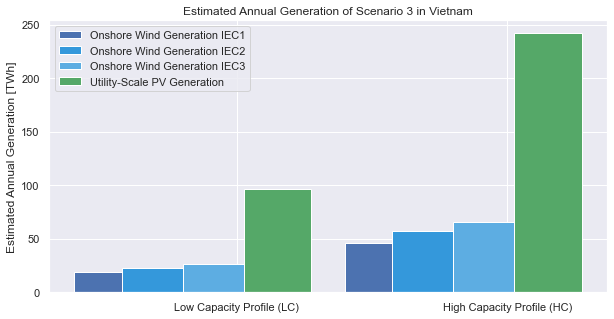

In [31]:
y_pos = np.arange(len(cap_arr))
# wind class IEC1-3 needs to be separated
wt_gen1_arr = [wt_ag_cf1_lc, wt_ag_cf1_hc]
wt_gen2_arr = [wt_ag_cf2_lc, wt_ag_cf2_hc]
wt_gen3_arr = [wt_ag_cf3_lc, wt_ag_cf3_hc]
pv_gen_arr = [pv_ag_lc, pv_ag_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
wt1_rects = plt.bar(y_pos - 0.45, wt_gen1_arr, width= 0.3,  color='b', label='Onshore Wind Generation IEC1')
wt2_rects = plt.bar(y_pos - 0.3, wt_gen2_arr, width= 0.25,  color='#3498DB', label='Onshore Wind Generation IEC2')
wt3_rects = plt.bar(y_pos - 0.05, wt_gen3_arr, width= 0.3,  color='#5DADE2', label='Onshore Wind Generation IEC3')
pv_rects = plt.bar(y_pos + 0.15, pv_cap_arr, width=0.25,  color='g', label='Utility-Scale PV Generation')
plt.xticks(y_pos, cap_arr)
plt.ylabel('Estimated Annual Generation [TWh]')
plt.title('Estimated Annual Generation of Scenario 3 in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_generation_scenario3_wind_solar.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

## 4. Method II: Calculate the potentials capacity & annual generation via hourly data

Check the data type of each column in current dataframe df

In [12]:
df.dtypes

latitude                                                     float64
longitude                                                    float64
time                                                  datetime64[ns]
year                                                           int64
month                                                          int64
day                                                            int64
hour                                                           int64
u-component_of_wind_speed_at_height_100m[m/s]                float32
v-component_of_wind_speed_at_height_100m[m/s]                float32
wind_speed_at_height_100m[m/s]                               float32
total_sky_direct_solar_radiation_at_surface[J/m2]            float32
total_sky_direct_solar_radiation_at_surface[Wh/m2]           float32
dtype: object

In [13]:
df.head()

,latitude,longitude,time,year,month,day,hour,u-component_of_wind_speed_at_height_100m[m/s],v-component_of_wind_speed_at_height_100m[m/s],wind_speed_at_height_100m[m/s],total_sky_direct_solar_radiation_at_surface[J/m2],total_sky_direct_solar_radiation_at_surface[Wh/m2]
0,24.0,101.0,2020-01-01 00:00:00,2020,1,1,0,0.498847,0.980772,1.100346,0.000,0.000000
1,24.0,101.0,2020-01-01 01:00:00,2020,1,1,1,0.199315,0.907117,0.928756,24523.625,6.812118
2,24.0,101.0,2020-01-01 02:00:00,2020,1,1,2,0.110454,0.916045,0.922680,97986.875,27.218576
3,24.0,101.0,2020-01-01 03:00:00,2020,1,1,3,0.580720,0.776548,0.969671,263574.875,73.215240
4,24.0,101.0,2020-01-01 04:00:00,2020,1,1,4,0.564745,0.695081,0.895586,266317.625,73.977119


### a. Calculate the hourly data of wind and solar resources

Use average value of each hours to represent the overall time-series data across the country <br>
*The data will have 8784 rows (366 day or 8784 hours in 2020), and hence it might take 15-20 minutes to complete the calculation) <br>
*For normalisation of data, the data in February 29th will be removed in order to keep all years in 8760 hours

In [14]:
# Creating an empty Dataframe with column names only
new_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'average_wind_speed_at_height_100m[m/s]', 'average_sky_direct_solar_radiation_at_surface[Wh/m2]'])
#new_df['year','month','day', 'hour'] = new_df['year','month','day', 'hour'].astype('Int64')

for i in range(1, 13): # months from January to December
    for j in range(1,32): # day from 1 to 31 
        for k in range (0,24): # hours from 0 to 23
            select_df = df.loc[(df['month'] == i) & (df['day'] == j) & (df['hour'] == k)]
            avg_wind = select_df['wind_speed_at_height_100m[m/s]'].mean(axis = 0, skipna = True)
            avg_solar = select_df['total_sky_direct_solar_radiation_at_surface[Wh/m2]'].mean(axis = 0, skipna = True)
            new_df = new_df.append({'time': select_df['time'],
                                    'year': 2020,
                                    'month': i, 
                                    'day': j, 
                                    'hour': k, 
                                    'average_wind_speed_at_height_100m[m/s]': avg_wind,
                                    'average_sky_direct_solar_radiation_at_surface[Wh/m2]': avg_solar}, ignore_index=True)

new_df_drop = new_df.dropna()
copy_new_df = new_df_drop.copy()
# stanardize the year in 8760 hrs
feb_df = copy_new_df[((copy_new_df['month'] == 2) & (copy_new_df['day'] == 29))].index
copy_new_df.drop(feb_df, inplace = True)

# give the time in hour-based
#new_df_drop['hour_number'] = np.arange(new_df_copy.shape[0])

# correct the value in time column from string into integer
copy_new_df['year'] = copy_new_df['year'].astype(np.int64)
copy_new_df['month'] = copy_new_df['month'].astype(np.int64)
copy_new_df['day'] = copy_new_df['day'].astype(np.int64)
copy_new_df['hour'] = copy_new_df['hour'].astype(np.int64)
copy_new_df

,time,year,month,day,hour,average_wind_speed_at_height_100m[m/s],average_sky_direct_solar_radiation_at_surface[Wh/m2]
0,0 2020-01-01 8784 2020-01-01 17...,2020,1,1,0,6.063948,7.086413
1,1 2020-01-01 01:00:00 8785 2020...,2020,1,1,1,6.001541,75.655800
2,2 2020-01-01 02:00:00 8786 2020...,2020,1,1,2,6.225554,194.520981
3,3 2020-01-01 03:00:00 8787 2020...,2020,1,1,3,6.448334,322.332581
4,4 2020-01-01 04:00:00 8788 2020...,2020,1,1,4,6.459966,400.505493
...,...,...,...,...,...,...,...
8923,8779 2020-12-31 19:00:00 17563 2020...,2020,12,31,19,7.531958,0.000000
8924,8780 2020-12-31 20:00:00 17564 2020...,2020,12,31,20,7.560935,0.000000
8925,8781 2020-12-31 21:00:00 17565 2020...,2020,12,31,21,7.599750,0.000000
8926,8782 2020-12-31 22:00:00 17566 2020...,2020,12,31,22,7.232974,0.000000


In [15]:
# convert time zone from UTC to UTC+7
utc_df = copy_new_df.copy()
utc_df['time'] = pd.to_datetime(utc_df[['year', 'month', 'day', 'hour']])
utc_df['time'] = pd.Series(utc_df['time'], dtype='datetime64[ns, Asia/Ho_Chi_Minh]')

# change year, month and day name
utc_df['year'] = pd.DatetimeIndex(utc_df['time']).year
utc_df['month'] = pd.DatetimeIndex(utc_df['time']).month
utc_df['day'] = pd.DatetimeIndex(utc_df['time']).day
utc_df['hour'] = pd.DatetimeIndex(utc_df['time']).hour

# add last six hours back to beginning and replace the time stamp
utc_df.iloc[-7:, 1] = 2020
utc_df['time'] = pd.to_datetime(utc_df[['year', 'month', 'day', 'hour']])

# sort by time
utc_df.sort_values(by=['time'], inplace = True)
utc_df.set_index(['time'],inplace=True)
utc_df = utc_df.iloc[: , 1:]
utc_df

,month,day,hour,average_wind_speed_at_height_100m[m/s],average_sky_direct_solar_radiation_at_surface[Wh/m2]
time,,,,,
2020-01-01 00:00:00,1,1,0,7.641319,0.0
2020-01-01 01:00:00,1,1,1,7.594773,0.0
2020-01-01 02:00:00,1,1,2,7.531958,0.0
2020-01-01 03:00:00,1,1,3,7.560935,0.0
2020-01-01 04:00:00,1,1,4,7.599750,0.0
...,...,...,...,...,...
2020-12-31 19:00:00,12,31,19,7.427829,0.0
2020-12-31 20:00:00,12,31,20,7.573410,0.0
2020-12-31 21:00:00,12,31,21,7.639140,0.0


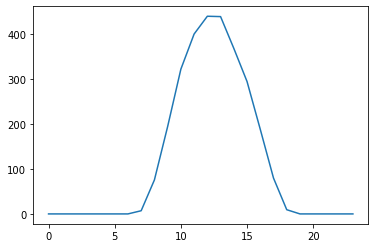

In [16]:
# recheck of the values with graph
day_df = utc_df.loc[(utc_df['month'] == 1) & (utc_df['day'] == 1)]
plt.plot(day_df['hour'], day_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'])

In [100]:
# Save csv file
utc_wind_df = utc_df.drop(columns=['average_sky_direct_solar_radiation_at_surface[Wh/m2]'])
utc_solar_df = utc_df.drop(columns=['average_wind_speed_at_height_100m[m/s]'])
utc_wind_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_speed_100m.csv', index = True)
utc_solar_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_solar_irradiation.csv', index = True)

### b. Plot a hourly graph of average total solar radiation at surface

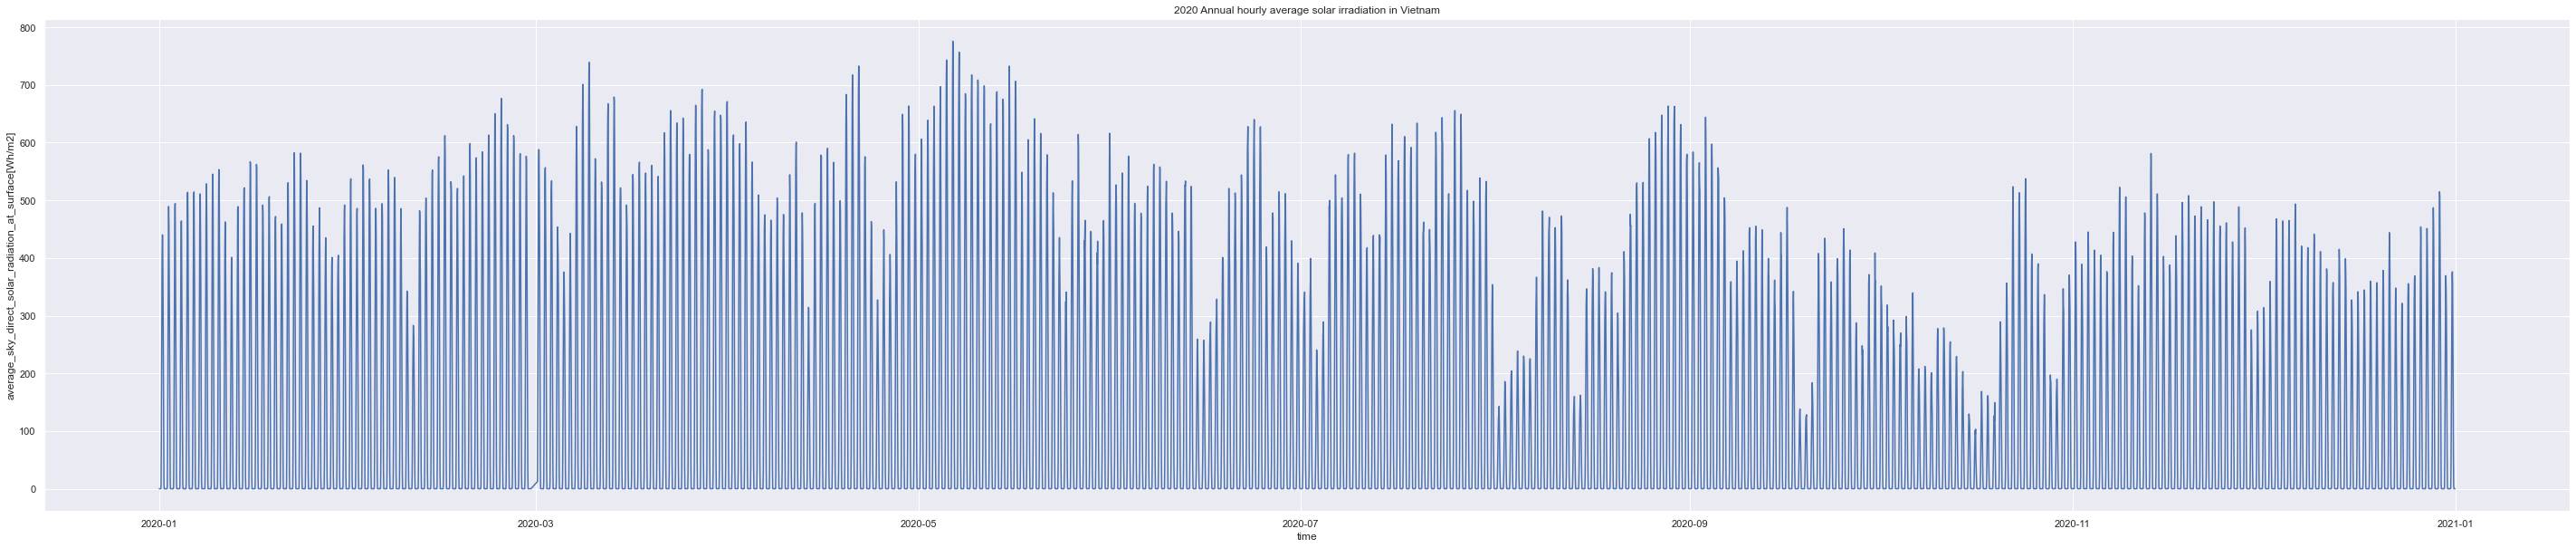

In [19]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="average_sky_direct_solar_radiation_at_surface[Wh/m2]", data=utc_solar_df)
plt.title('2020 Annual hourly average solar irradiation in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_solar_irradiation.tiff', dpi=300)
plt.show()

### c. Calculate Solar PV potential capacity based on HC/LC profile assumptions

In [53]:
# solar hourly annual yield
# HC/LC profile
# capactiy of one PV panel according to High Capacity (HC) Profile (450 Wp)
# capactiy of one PV panel according to High Capacity (HC) Profile (300 Wp)
# dimension: 1960x1380x40 mm
# pv_lc_c = 300wp
# pv_hc_c = 450wp
# 
# efficiency factor of the PV modules: 20 (%)
# pv_ef = 0.2

# total amount of pv that can be installed on available land
pv_amount = land_sum / (1960*1380/10**12)

pv_hc_ts_df = utc_solar_df.copy()
pv_lc_ts_df = utc_solar_df.copy()

# define maximum hourly geneartion
pv_hc_ts_df.loc[pv_hc_ts_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'] >pv_hc_c, "average_sky_direct_solar_radiation_at_surface[Wh/m2]"] = pv_hc_c
pv_lc_ts_df.loc[pv_lc_ts_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'] >pv_lc_c, "average_sky_direct_solar_radiation_at_surface[Wh/m2]"] = pv_lc_c

# annual solar generation of one pv
pv_hc_ts_sum = pv_hc_ts_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'].sum(axis = 0, skipna = True)*pv_ef/10**6
pv_lc_ts_sum = pv_lc_ts_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'].sum(axis = 0, skipna = True)*pv_ef/10**6

# annual total solar geneartion of all pv
#pv_hc_ts_all = pv_hc_ts_sum*pv_amount/10**6
#pv_lc_ts_all = pv_lc_ts_sum*pv_amount/10**6
pv_hc_ts_all = pv_hc_ts_sum*land_sum
pv_lc_ts_all = pv_lc_ts_sum*land_sum

# total install capacity of all pv
pv_hc_cp = pv_amount*pv_hc_c/10**9
pv_lc_cp = pv_amount*pv_lc_c/10**9

# capacity factor
pv_hc_cf = pv_hc_ts_all*10**3/(pv_hc_cp*8760)
pv_lc_cf = pv_lc_ts_all*10**3/(pv_hc_cp*8760)

print('Annual total solar generation:', 
      '\n (1) LC Profile:', pv_lc_ts_all, 'TWh',  '\n (2) HC Profile:',pv_hc_ts_all, 'TWh', 
      '\n Total install capacity:', 
      '\n (1) LC Profile:', pv_lc_cp, 'GW', '\n (2) HC Profile:',pv_hc_cp, 'GW', 
      '\n Capacity Factor', 
      '\n (1) LC Profile:', pv_lc_cf, '\n (2) HC Profile:',pv_hc_cf)



# Compared to the estimation in previous method:
# Utility-Scale PV estimated annual generation of scenario 3 in Vietnam : 
# (1) LC Profile: 125.94793806548785 TWh 
# (2) HC Profile: 314.86984516371956 TWh

# Utility-Scale PV potential capacity of scenario 3 in Vietnam : 
# (1) LC Profile: 96.70694825502545 GW 
# (2) HC Profile: 241.7673706375636 GW

# Utility-Scale PV capacity factor of scenario 3 in Vietnam : 
# (1) LC Profile: 0.14867203194863843 
# (2) HC Profile: 0.1486720319486384  

Annual total solar generation: 
 (1) LC Profile: 284.6246278421907 TWh 
 (2) HC Profile: 350.49755460410927 TWh 
 Total install capacity: 
 (1) LC Profile: 178.7691294273614 GW 
 (2) HC Profile: 268.15369414104214 GW 
 Capacity Factor 
 (1) LC Profile: 0.12116706419605221 
 (2) HC Profile: 0.149209715340663


### d. Calculate and plot annual solar generation 

In [54]:
# Save csv file of annual total solar geneartion of all pv
pv_lc_ts_all_df = pv_lc_ts_df.rename(columns={'average_sky_direct_solar_radiation_at_surface[Wh/m2]': 'annual_pv_generation[TWh]'})
pv_hc_ts_all_df = pv_hc_ts_df.rename(columns={'average_sky_direct_solar_radiation_at_surface[Wh/m2]': 'annual_pv_generation[TWh]'})
pv_lc_ts_all_df['annual_pv_generation[TWh]'] = pv_hc_ts_all_df['annual_pv_generation[TWh]']*pv_amount/10**12
pv_hc_ts_all_df['annual_pv_generation[TWh]'] = pv_hc_ts_all_df['annual_pv_generation[TWh]']*pv_amount/10**12
pv_lc_ts_all_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_lc_profile.csv', index = True)
pv_hc_ts_all_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_hc_profile.csv', index = True)

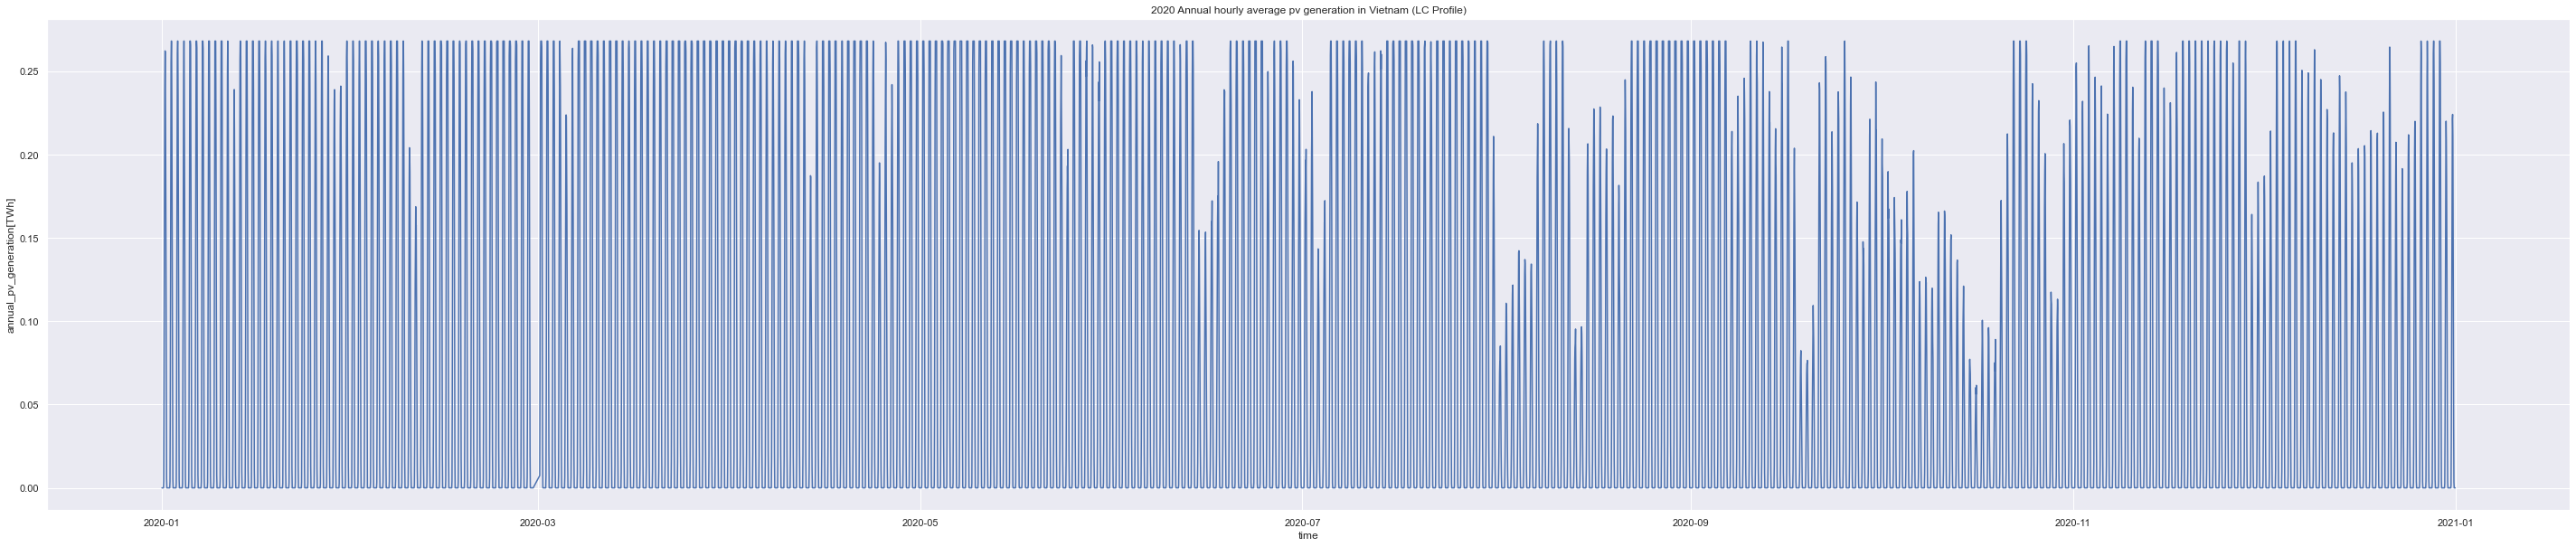

In [56]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="annual_pv_generation[TWh]", data=pv_lc_ts_all_df)
plt.title('2020 Annual hourly average pv generation in Vietnam (LC Profile)')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_lc_profile.tiff', dpi=300)
plt.show()

### e. Plot a hourly graph of average wind speed at height 100m

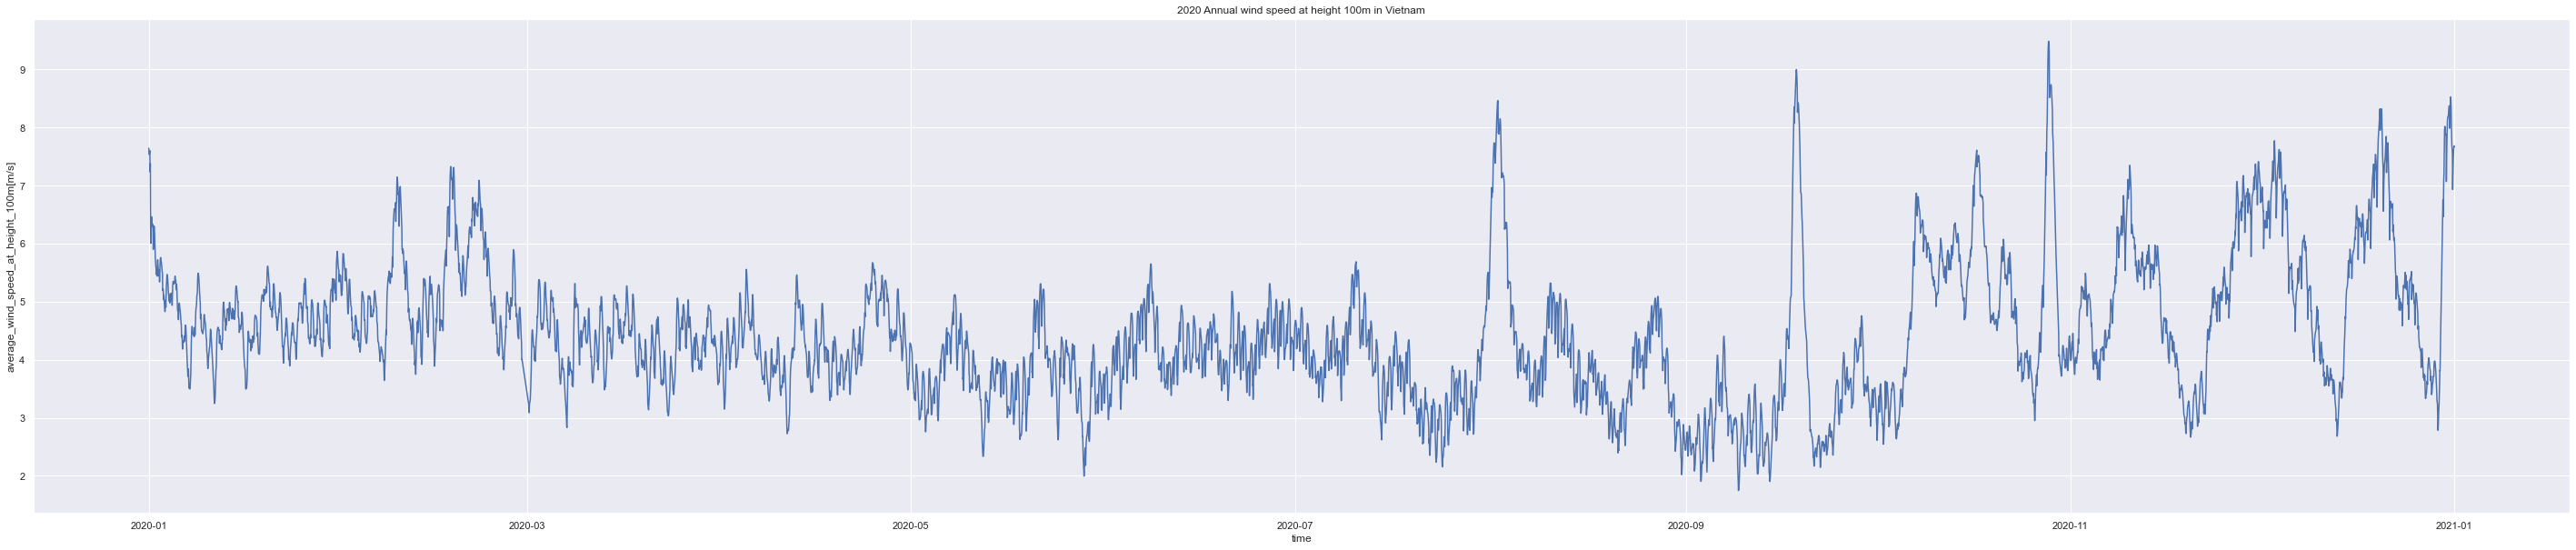

In [97]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="average_wind_speed_at_height_100m[m/s]", data=utc_wind_df)
plt.title('2020 Annual wind speed at height 100m in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_speed.tiff', dpi=300)
plt.show()

### f. Calculate Wind potential capacity based on HC/LC profile assumptions

Wind Turbine selection:
1. High Capacity (HC) Profile (5 MW): Gamesa G128-5.0MW
https://en.wind-turbine-models.com/turbines/767-gamesa-g128-5.0mw <br>
Diameter: 128m <br>
Hub Height: 95m
2. Low Capacity (LC) Profile (2 MW): Dongfang G2000-116 / FD116-2000 geared
https://en.wind-turbine-models.com/turbines/2229-dongfang-g2000-116-fd116-2000-geared <br>
Diameter: 116m <br>
Hub Height: 90m

In [481]:
utc_wind_df.head()

,month,day,hour,average_wind_speed_at_height_100m[m/s]
time,,,,
2020-01-01 00:00:00,1,1,0,7.641319
2020-01-01 01:00:00,1,1,1,7.594773
2020-01-01 02:00:00,1,1,2,7.531958
2020-01-01 03:00:00,1,1,3,7.560935
2020-01-01 04:00:00,1,1,4,7.599750


In [482]:
# define function of wind power curve conversion (variables: cut-in speed, cut-off speed, hourly wind speed dataframe, wind turbine power curve, number of turbines)
def wind_p_curve(cut_in,cut_off, power_df,pc_value_mw, wt_amount):
    # excluding cut-in and cut-off speeds
    for i in range(8760):
        if (power_df.iat[i,3] <cut_in) or (power_df.iat[i,3] >cut_off):
            power_df.iat[i,3] = 0

    # covert wind speed into power generation according to power curve
    level = len(pc_value_mw)
    for speed in range(level):
        for i in range(8760):
            if power_df.iat[i,3] >= (speed+3) and wind_power_df.iat[i,3] <(speed+4):
                power_df.iat[i,3] = pc_value_mw[speed]
           
    power_df.rename(columns={'average_wind_speed_at_height_100m[m/s]': 'hourly_wind_generation[TWh]'}, inplace = True)
    power_df['hourly_wind_generation[TWh]'] = power_df['hourly_wind_generation[TWh]']*wt_amount/10**6 

In [483]:
# wind
# HC/LC profile
# capactiy of one wind turbine according to High Capacity (HC) Profile (5 MW)
# wt_hc_c = 5

# HC Profile wind turbine power curve Gamesa G128-5.0MW https://en.wind-turbine-models.com/turbines/767-gamesa-g128-5.0mw
pc_value_hc_mw = [0.059, 0.195, 0.420, 0.786, 1.296, 
            1.943, 2.699, 3.487, 4.174, 4.639, 
            4.875, 4.965, 5.000, 5.000, 4.984,
            4.944, 4.859, 4.722, 4.541, 4.331,
            4.108, 3.883, 3.661, 3.447, 3.247]
# HC Profile wind turbine power curve Gamesa G128-4.5MW https://en.wind-turbine-models.com/turbines/156-gamesa-g128-4.5mw
#pc_value_hc_mw = [0.005, 0.205, 0.517, 0.985, 1.643, 
#            2.483, 3.395, 4.027, 4.372, 4.497, 
#            4.5, 4.5, 4.5, 4.5, 4.5,
#            4.5, 4.5, 4.5, 4.5, 4.5,
#            ]

# capactiy of one wind turbine according to Low Capacity (LC) Profile (2 MW)
# wt_lc_c = 2

# LC Profile wind turbine power curve Dongfang G2000-116 / FD116-2000 geared https://en.wind-turbine-models.com/turbines/2229-dongfang-g2000-116-fd116-2000-geared
pc_value_lc_mw = [0.033, 0.165, 0.358, 0.634, 1.020, 
            1.530, 2, 2, 2, 2, 
            2,2,2,2,2,
            2,2,2,2,2]

# distance between wind turbine: L*W = (5*rotor diameter)*(5*rotor diameter) (km2)
wt_d_hc = 5*0.128*5*0.128
wt_d_lc = 5*0.116*5*0.116

# total amount of pv that can be installed on available land
wd_amount_hc = land_sum / wt_d_hc
wd_amount_lc = land_sum / wt_d_lc

wind_power_hc_df = utc_wind_df.copy()
wind_power_lc_df = utc_wind_df.copy()

# run power curve function to execute generation
# function of wind power curve conversion (variables: cut-in speed, cut-off speed, hourly wind speed dataframe, wind turbine power curve, number of turbines)
wind_p_curve(3,20, wind_power_hc_df,pc_value_hc_mw, wd_amount_hc)
wind_p_curve(3,20, wind_power_lc_df,pc_value_lc_mw, wd_amount_lc)

In [484]:
wind_power_hc_df.head()

,month,day,hour,hourly_wind_generation[TWh]
time,,,,
2020-01-01 00:00:00,1,1,0,0.0051
2020-01-01 01:00:00,1,1,1,0.0051
2020-01-01 02:00:00,1,1,2,0.0051
2020-01-01 03:00:00,1,1,3,0.0051
2020-01-01 04:00:00,1,1,4,0.0051


In [485]:
wind_power_lc_df.head()

,month,day,hour,hourly_wind_generation[TWh]
time,,,,
2020-01-01 00:00:00,1,1,0,0.004887
2020-01-01 01:00:00,1,1,1,0.004887
2020-01-01 02:00:00,1,1,2,0.004887
2020-01-01 03:00:00,1,1,3,0.004887
2020-01-01 04:00:00,1,1,4,0.004887


### g. Calculate and plot annual wind generation 

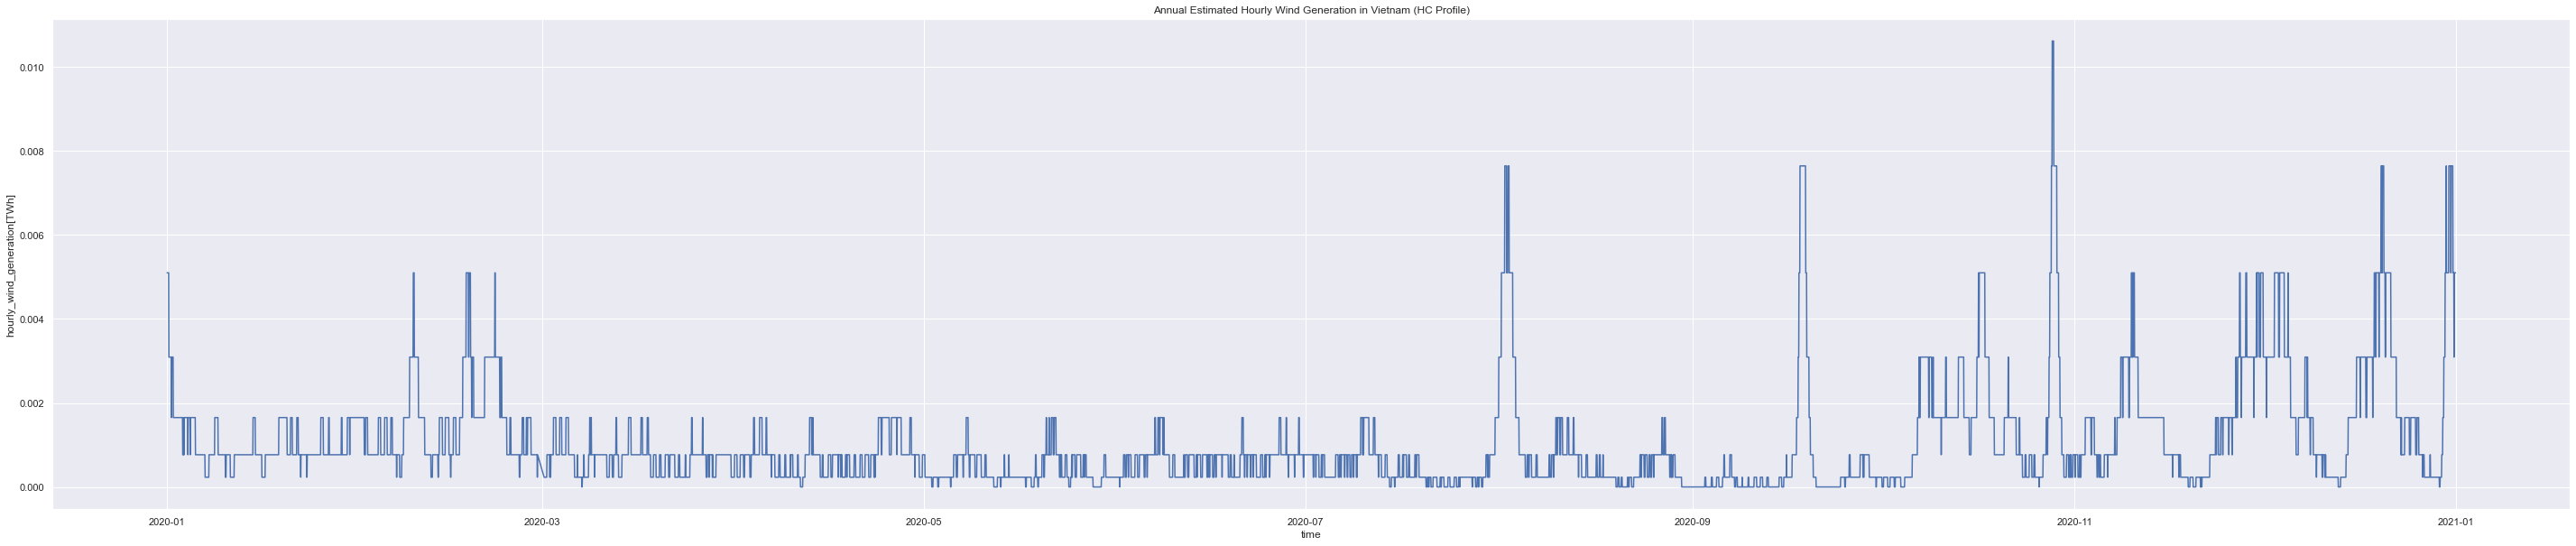

In [492]:
sns.lineplot(x="time", y="hourly_wind_generation[TWh]", data=wind_power_hc_df)
plt.title('Annual Estimated Hourly Wind Generation in Vietnam (HC Profile)')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_hc_profile.tiff', dpi=300)
plt.show()

In [488]:
# annual total geneartion of all wind turbines
wd_hc_ts_sum = wind_power_hc_df['hourly_wind_generation[TWh]'].sum(axis = 0, skipna = True)
wd_lc_ts_sum = wind_power_lc_df['hourly_wind_generation[TWh]'].sum(axis = 0, skipna = True)

# total install capacity of all pv
wd_hc_cp = wd_amount_hc*wt_hc_c/10**3
wd_lc_cp = wd_amount_lc*wt_lc_c/10**3

# capacity factor
#wd_hc_cf = pv_hc_ts_all*10**3/(pv_hc_cp*8760)
wd_hc_cf = wd_hc_ts_sum*10**3/(wd_hc_cp*8760)
wd_lc_cf = wd_lc_ts_sum*10**3/(wd_lc_cp*8760)

print('Annual total wind generation:', 
      '\n (1) LC Profile:', wd_lc_ts_sum, 'TWh', '\n (2) HC Profile:',wd_hc_ts_sum, 'TWh', 
      '\n Total install capacity:', 
      '\n (1) LC Profile:', wd_lc_cp, 'GW', '\n (2) HC Profile:',wd_hc_cp, 'GW', 
      '\n Capacity Factor', 
      '\n (1) LC Profile:', wd_lc_cf, '\n (2) HC Profile:',wd_hc_cf)


# Onshore windfarm estimated annual generation of scenario 3 in Vietnam : 
# (1) LC Profile in wind class IEC1: 18.556895401360375 TWh 
# (2) LC Profile in wind class IEC2: 22.913443443081245 TWh 
# (3) LC Profile in wind class IEC3: 26.249440358430437 TWh 
# (4) HC Profile in wind class IEC1: 46.39223850340094 TWh 
# (5) HC Profile in wind class IEC2: 57.28360860770312 TWh 
# (6) HC Profile in wind class IEC3: 65.6236008960761 TWh

# Onshore wind potential capacity of scenario 3 in Vietnam : 
# (1) LC Profile: 12.894259767336726 GW 
# (2) HC Profile: 32.235649418341815 GW

Annual total wind generation: 
 (1) LC Profile: 8.933793054368419 TWh 
 (2) HC Profile: 9.068889249398598 TWh 
 Total install capacity: 
 (1) LC Profile: 9.582535498912549 GW 
 (2) HC Profile: 19.67507899068714 GW 
 Capacity Factor 
 (1) LC Profile: 0.10642688356164381 
 (2) HC Profile: 0.052617899543379004


In [491]:
utc_wind_df['average_wind_speed_at_height_100m[m/s]'].mean(axis = 0, skipna = True)

4.463459263653515

Since the annual mean speed is at 4.4m/s and initial setup of hub height is at 100m, the capacity factor of wind turbines will be relatively low due to oversizing of wind turbines. Compared to the ideal situation evaluated by mean power density, the values can be improved by selection of wind turbines.

In [489]:
# Save csv file of annual total solar geneartion of all pv
wd_hc_ts_all_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_hc_profile.csv', index = True)
wd_lc_ts_all_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_lc_profile.csv', index = True)